# Drought Prediction: Modeling

#### Load Libraries and dataset (non-standardized).

In [13]:
#Import pandas, numpy, and StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor

In [2]:
# Local location of the data
# local_data = 'D:\\Data_Science\\DroughtProject\\Data\\' # Location on Windows
local_data = '/home/chad/Data/Drought_Prediction/' # Location on Linux

# Load the dataset that contains training (meteorological variables) resampled weekly with mean, max, min
# and the soil variables that have been merged on the county 'fips' value
tsm = pd.read_csv(local_data + 'train_soil_stats.csv',
                        parse_dates=['date'],
                        index_col=['index'],
                        header=0)

In [3]:
# Confirm dataset loaded properly.
tsm

,fips,date,score,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
index,,,,,,,,,,,,,,,,,,,,,
0,1001,2000-01-04,1.0,5.005000,100.375000,9.562500,15.330000,12.707500,12.710000,21.145000,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-11,2.0,5.684286,100.665714,5.951429,9.192857,4.908571,4.934286,15.732857,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-18,2.0,0.832857,101.275714,6.692857,10.118571,6.711429,6.735714,16.931429,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-25,2.0,3.641429,100.187143,4.220000,4.458571,-0.224286,-0.132857,10.217143,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-02-01,1.0,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759899,56043,2016-12-06,0.0,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2759900,56043,2016-12-13,0.0,0.350000,82.865714,1.884286,-7.621429,-12.220000,-11.961429,-2.532857,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2759901,56043,2016-12-20,0.0,0.812857,82.752857,1.757143,-9.688571,-13.777143,-13.368571,-3.805714,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [5]:
# Confirming expected datatypes.
tsm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2759904 entries, 0 to 2759903
Data columns (total 88 columns):
 #   Column            Dtype         
---  ------            -----         
 0   fips              int64         
 1   date              datetime64[ns]
 2   score             float64       
 3   PRECTOT_mean      float64       
 4   PS_mean           float64       
 5   QV2M_mean         float64       
 6   T2M_mean          float64       
 7   T2MDEW_mean       float64       
 8   T2MWET_mean       float64       
 9   T2M_MAX_mean      float64       
 10  T2M_MIN_mean      float64       
 11  T2M_RANGE_mean    float64       
 12  TS_mean           float64       
 13  WS10M_mean        float64       
 14  WS10M_MAX_mean    float64       
 15  WS10M_MIN_mean    float64       
 16  WS10M_RANGE_mean  float64       
 17  WS50M_mean        float64       
 18  WS50M_MAX_mean    float64       
 19  WS50M_MIN_mean    float64       
 20  WS50M_RANGE_mean  float64       
 21  PRECTOT_

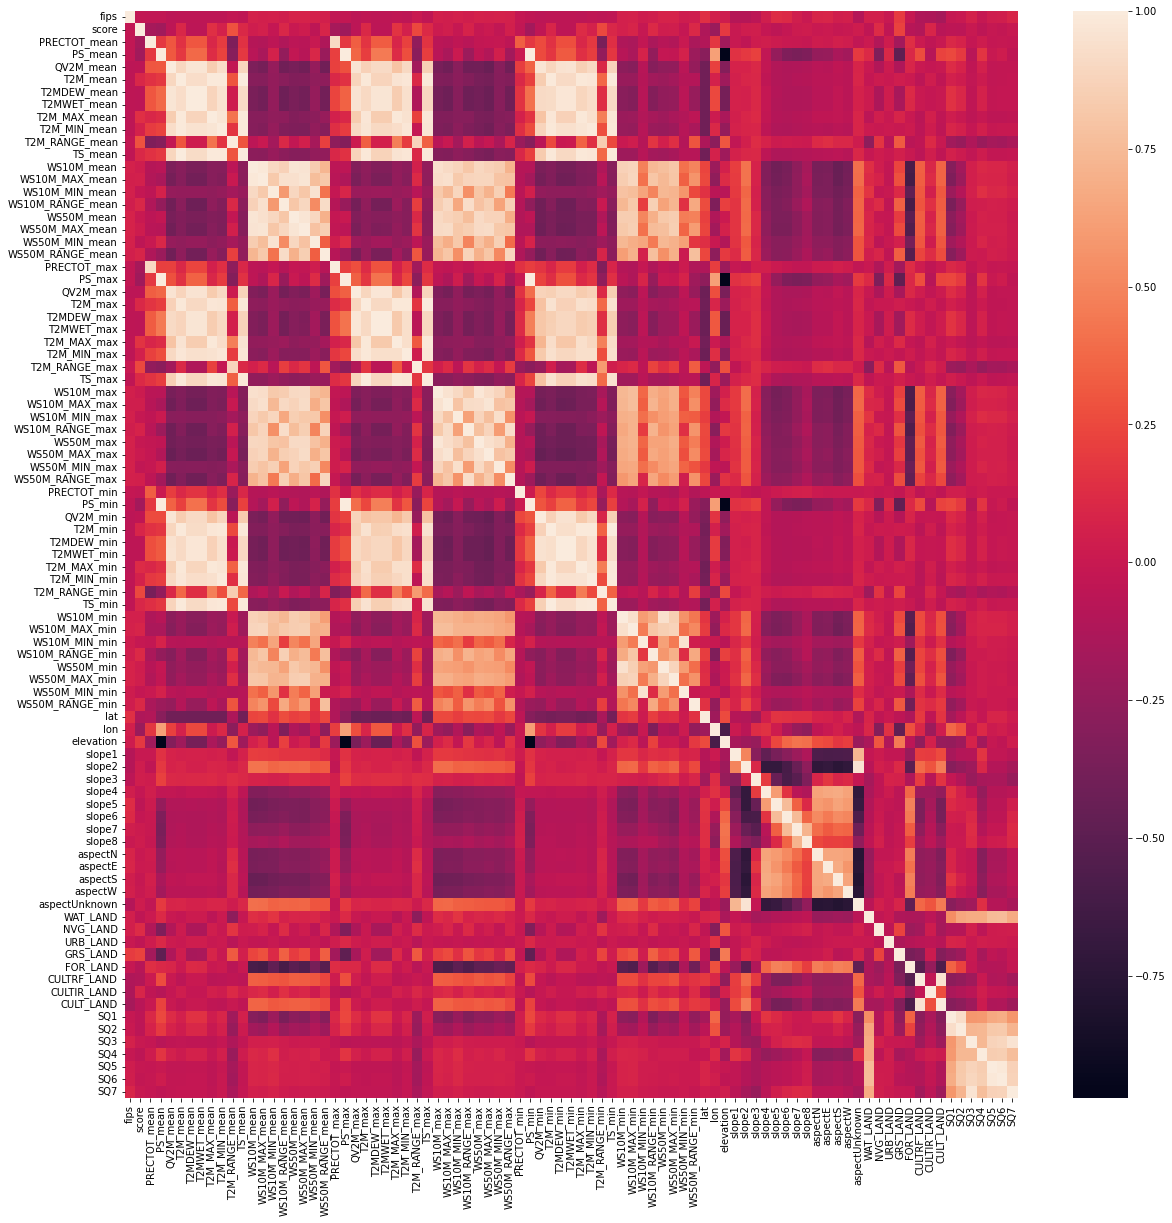

In [6]:
# Heatmap of correlation matrix for meteorological variables and drought score.
plt.subplots(figsize=(20,20))

# Heatmap with printed correlation numbers.
# sns.heatmap(train_set.corr(), annot=True, fmt='.2f');

# Heatmap without printed correlation numbers.
sns.heatmap(tsm.corr());

#### A number of variables are correlated.  These variables (features) need to be removed or changed before inputting into Machine Learning algorithms that produce skewed results when input variables are correlated. 

## Train/Test Split

In [8]:
# Breaking out independent numerical variables from target variable, categorical variable ('fips'), and date.
cols = tsm.columns.tolist()
features = cols[3:]

# Separating out the features
X = tsm.loc[:, features].values

# Separating out the target
y = tsm.loc[:,['score']].values

# Split dataset into preliminary training set and initial test set for model selection.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [9]:
X_train.shape, X_test.shape

((1931932, 85), (827972, 85))

In [10]:
y_train.shape, y_test.shape

((1931932, 1), (827972, 1))

## Initial Not-Even-A-Model

In [11]:
# Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

0.825286361942346

In [14]:
# Fit the dummy regressor on the training data
# This is an absolute baseline for what is the guess for drought score without any model or variable input.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[0.82528636]])

###  Metrics